## Pipeline Exploration
In this notebook I explored some options with PCA pipelines.  While PCA is somewhat helpful, it really only brings the accuracy of outcome selection up to ~55%.  PCA identified the home streak and the away win percentage to be the most valuable features. Next I will explore what happens if I include run diffrential...

And now we shall.  I have created a dataset that includes total RS, RA, and run differential for the season and games over 500

4/1/2020

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve, auc
from numpy import interp
from sklearn.model_selection import cross_val_score

In [2]:
#Get CSV's into memory
df = pd.read_csv("2019_all.csv")
team_runs = {}

def get_teams():
    teams = [item.strip() for item in open("all_teams.txt",'r')]
    return teams

teams = get_teams()
#make team dictionary
for team in teams:
    team_runs[team] = pd.read_csv(f"Data\\Team_Runs\\2019_{team}_runs.csv")
df

,Date,Home_Win,Home,Away,Home_Streak,Away_Streak,Home_Win_Percentage,Away_Win_Percentage
0,thursday mar 28,W,OAK,LAA,-2,0,0.000000,0.000000
1,friday mar 29,L,OAK,LAA,1,-1,0.333333,0.000000
2,saturday mar 30,W,OAK,LAA,-1,1,0.250000,0.500000
3,sunday mar 31,W,OAK,LAA,1,-1,0.400000,0.333333
4,monday apr 1,W,SEA,LAA,2,-2,0.833333,0.250000
...,...,...,...,...,...,...,...,...
2424,sunday apr 14,L,NYY,CHW,1,-1,0.428571,0.307692
2425,thursday jun 13,W,CHW,NYY,1,-1,0.484848,0.621212
2426,friday jun 14,W,CHW,NYY,2,-2,0.492537,0.611940
2427,saturday jun 15,L,CHW,NYY,3,-3,0.500000,0.602941


In [267]:
#team files
team_runs['OAK']

,Gm#,Date,RS,RA,RS_Total,RA_Total,Delta,Delta_Percentage,Wins_Total
0,1,wednesday mar 20,7,9,0,0,0,0.0000,0
1,2,thursday mar 21,4,5,7,9,-2,0.7778,0
2,3,thursday mar 28,4,0,11,14,-3,0.7857,0
3,4,friday mar 29,2,6,15,14,1,1.0714,1
4,5,saturday mar 30,4,2,17,20,-3,0.8500,1
...,...,...,...,...,...,...,...,...,...
157,158,wednesday sep 25,3,2,834,670,164,1.2448,94
158,159,thursday sep 26,3,1,837,672,165,1.2455,95
159,160,friday sep 27,3,4,840,673,167,1.2481,96
160,161,saturday sep 28,1,0,843,677,166,1.2452,96


In [146]:
"""
Create the Dataset"""
#X = np.zeros((len(df),2*(len(team_runs[teams[0]].columns[4:])+2)))
X = np.zeros((len(df),15))
y = df['Home_Win'].values
for i in range(len(df)):
    home_df = team_runs[df.loc[i][2]]
    away_df = team_runs[df.loc[i][3]]
    a = df.loc[i]
    home_stats = np.ravel(home_df.loc[home_df.loc[:,'Date'] == df.loc[i][0]].values[:,4:])
    away_stats = np.ravel(away_df.loc[away_df.loc[:,'Date'] == df.loc[i][0]].values[:,4:])
    
    #just the delta run stat
    #home_stats = np.ravel(home_df.loc[home_df.loc[:,'Date'] == df.loc[i][0]].values[:,7])
    #away_stats = np.ravel(away_df.loc[away_df.loc[:,'Date'] == df.loc[i][0]].values[:,7])
    delta_win_percent = a[6]-a[7]

    #X[i] = (np.concatenate([[a[4]], [a[6]] ,home_stats, away_stats, [a[5]],[a[7]]]))
    X[i] = (np.concatenate([[delta_win_percent], [a[6]],[a[4]] ,home_stats, away_stats,[a[7]], [a[5]]]))


In [185]:
new_df = pd.DataFrame()
new_df = df.loc[:,df.columns[0:4]]
new_df["Win Percent Delta"] = df.loc[:,df.columns[6]].values-df.loc[:,df.columns[7]].values
new_df["Streak Delta"] = df.loc[:,df.columns[4]].values-df.loc[:,df.columns[5]].values


In [262]:
#create new columns for df from team run dictionary
home_RS_total = []
home_RA_total = []
home_run_delt = []
home_run_dl_p = []
home_win_totl = []
away_RS_total = []
away_RA_total = []
away_run_delt = []
away_run_dl_p = []
away_win_totl = []

for i in range(len(df)):
    home_df = team_runs[df.loc[i][2]]
    away_df = team_runs[df.loc[i][3]]
    
    #locate game stats from the df's in the team dictionaries
    home_stats = (home_df.loc[home_df.loc[:,'Date'] == df.loc[i][0]])
    away_stats = (away_df.loc[away_df.loc[:,'Date'] == df.loc[i][0]])
    
    #Extract stats from df's
    home_RS_total.append(home_stats['RS_Total'].values)  
    home_RA_total.append(home_stats['RA_Total'].values)
    home_run_delt.append(home_stats['Delta'].values)
    home_run_dl_p.append(home_stats['Delta_Percentage'].values)
    home_win_totl.append(home_stats['Wins_Total'].values)    
    away_RS_total.append(away_stats['RS_Total'].values) 
    away_RA_total.append(away_stats['RA_Total'].values)     
    away_run_delt.append(away_stats['Delta'].values)   
    away_run_dl_p.append(away_stats['Delta_Percentage'].values)
    away_win_totl.append(away_stats['Wins_Total'].values)
     


In [265]:
RS_delta = np.ravel(home_RS_total) - np.ravel(away_RS_total)
RA_delta = np.ravel(home_RA_total) - np.ravel(away_RA_total)
RD_delta = np.ravel(home_run_delt) - np.ravel(away_run_delt)
RP_delta = np.ravel(home_run_dl_p) - np.ravel(away_run_dl_p)
WT_delta = np.ravel(home_win_totl) - np.ravel(away_win_totl)

RS_delta

array([ 11,  15,  11, ..., -74, -66, -70], dtype=int64)

In [268]:
new_df['Run Scored Delta']= RS_delta
new_df['Run Allowed Delta']= RA_delta
new_df['Run Delta Delta']= RD_delta
new_df['Run Delta Percent Delta']= RP_delta
new_df['Win Total Delta']= WT_delta

In [269]:
new_df

,Date,Home_Win,Home,Away,Win Percent Delta,Streak Delta,Run Scored Delta,Run Allowed Delta,Run Delta Delta,Run Delta Percent Delta,Win Total Delta
0,thursday mar 28,W,OAK,LAA,0.000000,-2,11,14,-3,0.7857,0
1,friday mar 29,L,OAK,LAA,0.333333,2,15,10,5,1.0714,1
2,saturday mar 30,W,OAK,LAA,-0.250000,-2,11,14,-3,-0.1500,0
3,sunday mar 31,W,OAK,LAA,0.066667,2,13,12,1,0.1545,1
4,monday apr 1,W,SEA,LAA,0.583333,4,39,23,16,0.6214,4
...,...,...,...,...,...,...,...,...,...,...,...
2424,sunday apr 14,L,NYY,CHW,0.120879,2,12,-29,41,0.5459,2
2425,thursday jun 13,W,CHW,NYY,-0.136364,2,-75,50,-125,-0.4098,-9
2426,friday jun 14,W,CHW,NYY,-0.119403,4,-74,49,-123,-0.3972,-8
2427,saturday jun 15,L,CHW,NYY,-0.102941,6,-66,41,-107,-0.3382,-7


In [271]:
X = new_df.loc[:,new_df.columns[4:]]
y = new_df.loc[:,new_df.columns[1]].values

In [272]:
#create win/loss mask
wins = df.loc[:,'Home_Win'] == 'W'
losses = df.loc[:,'Home_Win'] != 'W'

In [273]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
scaler = StandardScaler()
X_transform = scaler.fit_transform(X)
le = LabelEncoder()
y_label = le.fit_transform(y)
le.transform(['W','L'])

array([1, 0], dtype=int64)

In [274]:
from numpy import array
from numpy import mean
from numpy import cov
from numpy.linalg import eig
# define a matrix
A = array(X_transform)

# calculate the mean of each column
M = mean(A.T, axis=1)

# center columns by subtracting column means
C = A - M

# calculate covariance matrix of centered matrix. This is how much each columns varies with other columns
V = cov(C.T)

# eigendecomposition of covariance matrix.  The larger the eigenvalue, the more it matters
values, vectors = eig(V)
print(f'Eigenvalues: {values}')

# project data using the covariance matrix and the eigenvectors
P = vectors.T.dot(C.T)

xval = np.array([item[0] for item in P.T])
yval = np.array([item[1] for item in P.T])

Eigenvalues: [ 4.37076290e+00  8.71837589e-01  6.88902588e-01  7.84865838e-01
  2.35265262e-01  5.12488495e-02 -1.73559711e-18]


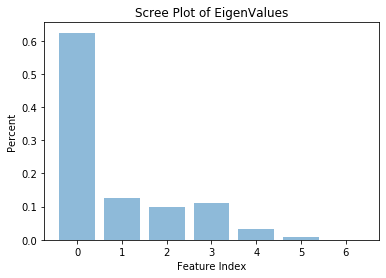

In [275]:
def create_scree(vector):
    total = sum(vector)
    percent = vector/total
    return percent

import matplotlib.pyplot as plt

plt.title('Scree Plot of EigenValues')
plt.ylabel('Percent')
plt.xlabel('Feature Index')
plt.bar([x for x in range(len(values))], create_scree(values), align='center', alpha=0.5)
plt.show()

## There is no separation of the data using PCA

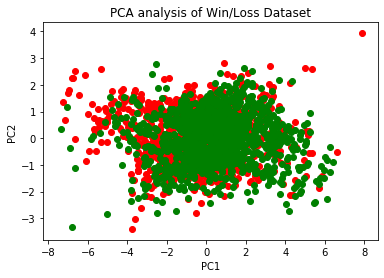

In [276]:
import matplotlib.pyplot as plt

#plot loses as red and wins as green
plt.scatter(xval[losses], yval[losses], color='red')                            
plt.scatter(xval[wins], yval[wins], color='green')

plt.title('PCA analysis of Win/Loss Dataset')
plt.xlabel('PC1')
plt.ylabel('PC2')

plt.show()

## PCA --> Logistic Pipeline

In [277]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = \
    train_test_split(X_transform, y_label, 
                     test_size=0.25,
                     stratify=y_label,
                     random_state=1)

In [278]:
from sklearn.pipeline import make_pipeline
pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=2),
                        LogisticRegression(penalty='l2', 
                                           random_state=1,
                                           solver='lbfgs',
                                           C=100.0))

In [279]:
pipe_lr.fit(X_train,y_train)
pipe_lr.score(X_test,y_test)

0.5723684210526315

In [280]:
from sklearn.model_selection import StratifiedKFold    

kfold = StratifiedKFold(n_splits=10).split(X_train, y_train)

scores = []
#This is for demonstration purposes only: just use the  cross validation scorer below
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print('Fold: %2d, Class dist.: %s, Acc: %.3f' % (k+1,
          np.bincount(y_train[train]), score))
    
print('\nCV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Fold:  1, Class dist.: [771 867], Acc: 0.612
Fold:  2, Class dist.: [772 867], Acc: 0.544
Fold:  3, Class dist.: [772 867], Acc: 0.571
Fold:  4, Class dist.: [772 867], Acc: 0.626
Fold:  5, Class dist.: [771 868], Acc: 0.588
Fold:  6, Class dist.: [771 868], Acc: 0.593
Fold:  7, Class dist.: [771 868], Acc: 0.527
Fold:  8, Class dist.: [771 868], Acc: 0.676
Fold:  9, Class dist.: [771 868], Acc: 0.610
Fold: 10, Class dist.: [771 868], Acc: 0.593

CV accuracy: 0.594 +/- 0.040


In [281]:
#sklearn has a cross validator built in so we don't need to loop through things manuially

scores = cross_val_score(estimator=pipe_lr,
                         X=X_train,
                         y=y_train,
                         cv=10,
                         n_jobs=1)
#print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.594 +/- 0.040


This is about 4% higher than the other pipeline, and unlike the NN it's accuracy does nto change with each iteration

# PCA -> NN Pipeline

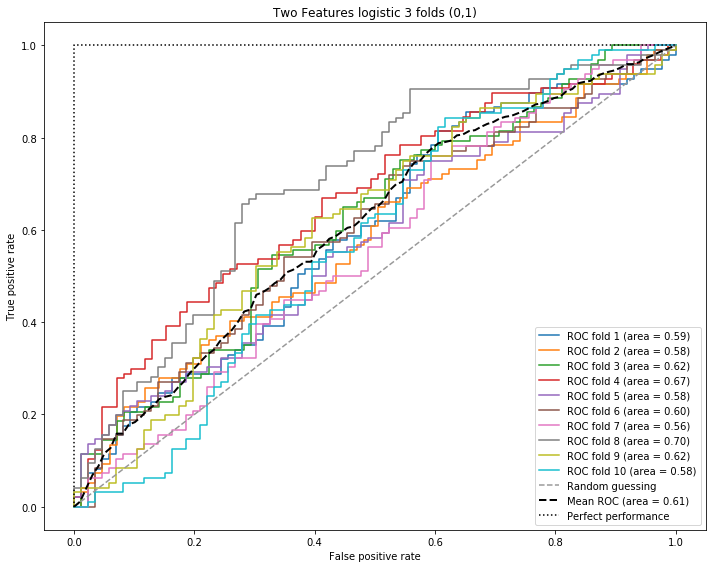

In [31]:
pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=2),
                        MLPClassifier(activation = "logistic", 
                                      solver='sgd',
                                      learning_rate_init = 0.1,
                                      learning_rate = "constant",
                                      momentum = 0.1,
                                      max_iter = 10000))
                    
# here we are selecting only 2 features from the dataset
X_train2 = X_train
#[:, [0,2,3]]
    
#You can set the cross validator here with the number of splits
cv = list(StratifiedKFold(n_splits=10).split(X_train, y_train))

fig = plt.figure(figsize=(10, 8))

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(cv):
    #Xtrain2 is used here for the fit, using only the features chosen above.  If you use the Xtrain data it will get 100%
    probas = pipe_lr.fit(X_train2[train],
                         y_train[train]).predict_proba(X_train2[test])

    fpr, tpr, thresholds = roc_curve(y_train[test],
                                     probas[:, 1],
                                     pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr,
             tpr,
             label='ROC fold %d (area = %0.2f)'
                   % (i+1, roc_auc))
plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         color=(0.6, 0.6, 0.6),
         label='Random guessing')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)
plt.plot([0, 0, 1],
         [0, 1, 1],
         linestyle=':',
         color='black',
         label='Perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.title("Two Features logistic 3 folds (0,1)")
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")

plt.tight_layout()
#plt.savefig('2_features_3folds.png', dpi=300)
plt.show()

## NN results

In [36]:
#sklearn has a cross validator built in so we don't need to loop through things manuially
for i in range(0,10):
    scores = cross_val_score(estimator=pipe_lr,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             n_jobs=1)
    #print('CV accuracy scores: %s' % scores)
    print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.531 +/- 0.055
CV accuracy: 0.533 +/- 0.061
CV accuracy: 0.543 +/- 0.060
CV accuracy: 0.546 +/- 0.056
CV accuracy: 0.533 +/- 0.060
CV accuracy: 0.531 +/- 0.046
CV accuracy: 0.543 +/- 0.044
CV accuracy: 0.543 +/- 0.057
CV accuracy: 0.541 +/- 0.030
CV accuracy: 0.543 +/- 0.041


Again, this is somewhat higher than the original tests, but interestingly has variation in the results...

# Naive Bayes

In [49]:
df

,Date,Home_Win,Home,Away,Home_Streak,Away_Streak,Home_Win_Percentage,Away_Win_Percentage
0,thursday mar 28,W,OAK,LAA,-2,0,0.000000,0.000000
1,friday mar 29,L,OAK,LAA,1,-1,0.333333,0.000000
2,saturday mar 30,W,OAK,LAA,-1,1,0.250000,0.500000
3,sunday mar 31,W,OAK,LAA,1,-1,0.400000,0.333333
4,monday apr 1,W,SEA,LAA,2,-2,0.833333,0.250000
...,...,...,...,...,...,...,...,...
2424,sunday apr 14,L,NYY,CHW,1,-1,0.428571,0.307692
2425,thursday jun 13,W,CHW,NYY,1,-1,0.484848,0.621212
2426,friday jun 14,W,CHW,NYY,2,-2,0.492537,0.611940
2427,saturday jun 15,L,CHW,NYY,3,-3,0.500000,0.602941


In [242]:
#X = df[:][df.columns[4:]].values
#y = df[:][df.columns[1]].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, random_state=0)

In [243]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))
print(f'Accuracy: {round(1-((y_test != y_pred).sum()/X_test.shape[0]),3)}')


Number of mislabeled points out of a total 1458 points : 620
Accuracy: 0.575


## Decision Tree

In [81]:
from sklearn.tree import DecisionTreeClassifier
tree_model = DecisionTreeClassifier(criterion='gini', 
                                    max_depth=10, 
                                    random_state=1)
tree_model.fit(X_train, y_train)
tree_model.score(X_test,y_test)

0.5541838134430727

In [145]:
X

array([[-2.        ,  0.        ,  0.        ,  0.        ],
       [ 1.        , -1.        ,  0.33333333,  0.        ],
       [-1.        ,  1.        ,  0.25      ,  0.5       ],
       ...,
       [ 2.        , -2.        ,  0.49253731,  0.6119403 ],
       [ 3.        , -3.        ,  0.5       ,  0.60294118],
       [-1.        ,  1.        ,  0.49275362,  0.60869565]])